In [1]:
from yo_fluq_ds import *
from tg.common.delivery.sagemaker import download_and_open_sagemaker_result, S3TrainingLogsLoader, TrainingLogsViewer
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from tg.common.ml import batched_training as bt
from tg.common.ml.miscellaneous import roc_optimal_threshold

tlw = TrainingLogsViewer

## Parameters optimization

First Stages:

* Find the biggest batch size that fits to the memory. Don't forget to check mini-batches.
* Make Adam algorithm work: it's better, but far more capricious.


### Network size and learning rate


In [2]:
df = pd.read_parquet('files/params_0.parquet')
df

,metric,ordinal,value,timestamp,job_id
0,roc_auc_score_test,0,0.984579,2023-01-27 11:52:16.384765,att-hs100-lr001-2023-01-27-11-42-37-234
1,roc_auc_score_display,0,0.987968,2023-01-27 11:52:16.384765,att-hs100-lr001-2023-01-27-11-42-37-234
2,loss,0,0.045863,2023-01-27 11:52:16.384765,att-hs100-lr001-2023-01-27-11-42-37-234
3,iteration,0,0.000000,2023-01-27 11:52:16.384765,att-hs100-lr001-2023-01-27-11-42-37-234
4,roc_auc_score_test,1,0.984847,2023-01-27 11:54:44.282659,att-hs100-lr001-2023-01-27-11-42-37-234
...,...,...,...,...,...
395,iteration,98,98.000000,2023-01-27 15:14:32.993998,att-hs10-lr005-2023-01-27-11-39-50-862
396,roc_auc_score_test,99,0.976433,2023-01-27 15:16:36.815010,att-hs10-lr005-2023-01-27-11-39-50-862
397,roc_auc_score_display,99,0.978493,2023-01-27 15:16:36.815010,att-hs10-lr005-2023-01-27-11-39-50-862
398,loss,99,0.048486,2023-01-27 15:16:36.815010,att-hs10-lr005-2023-01-27-11-39-50-862


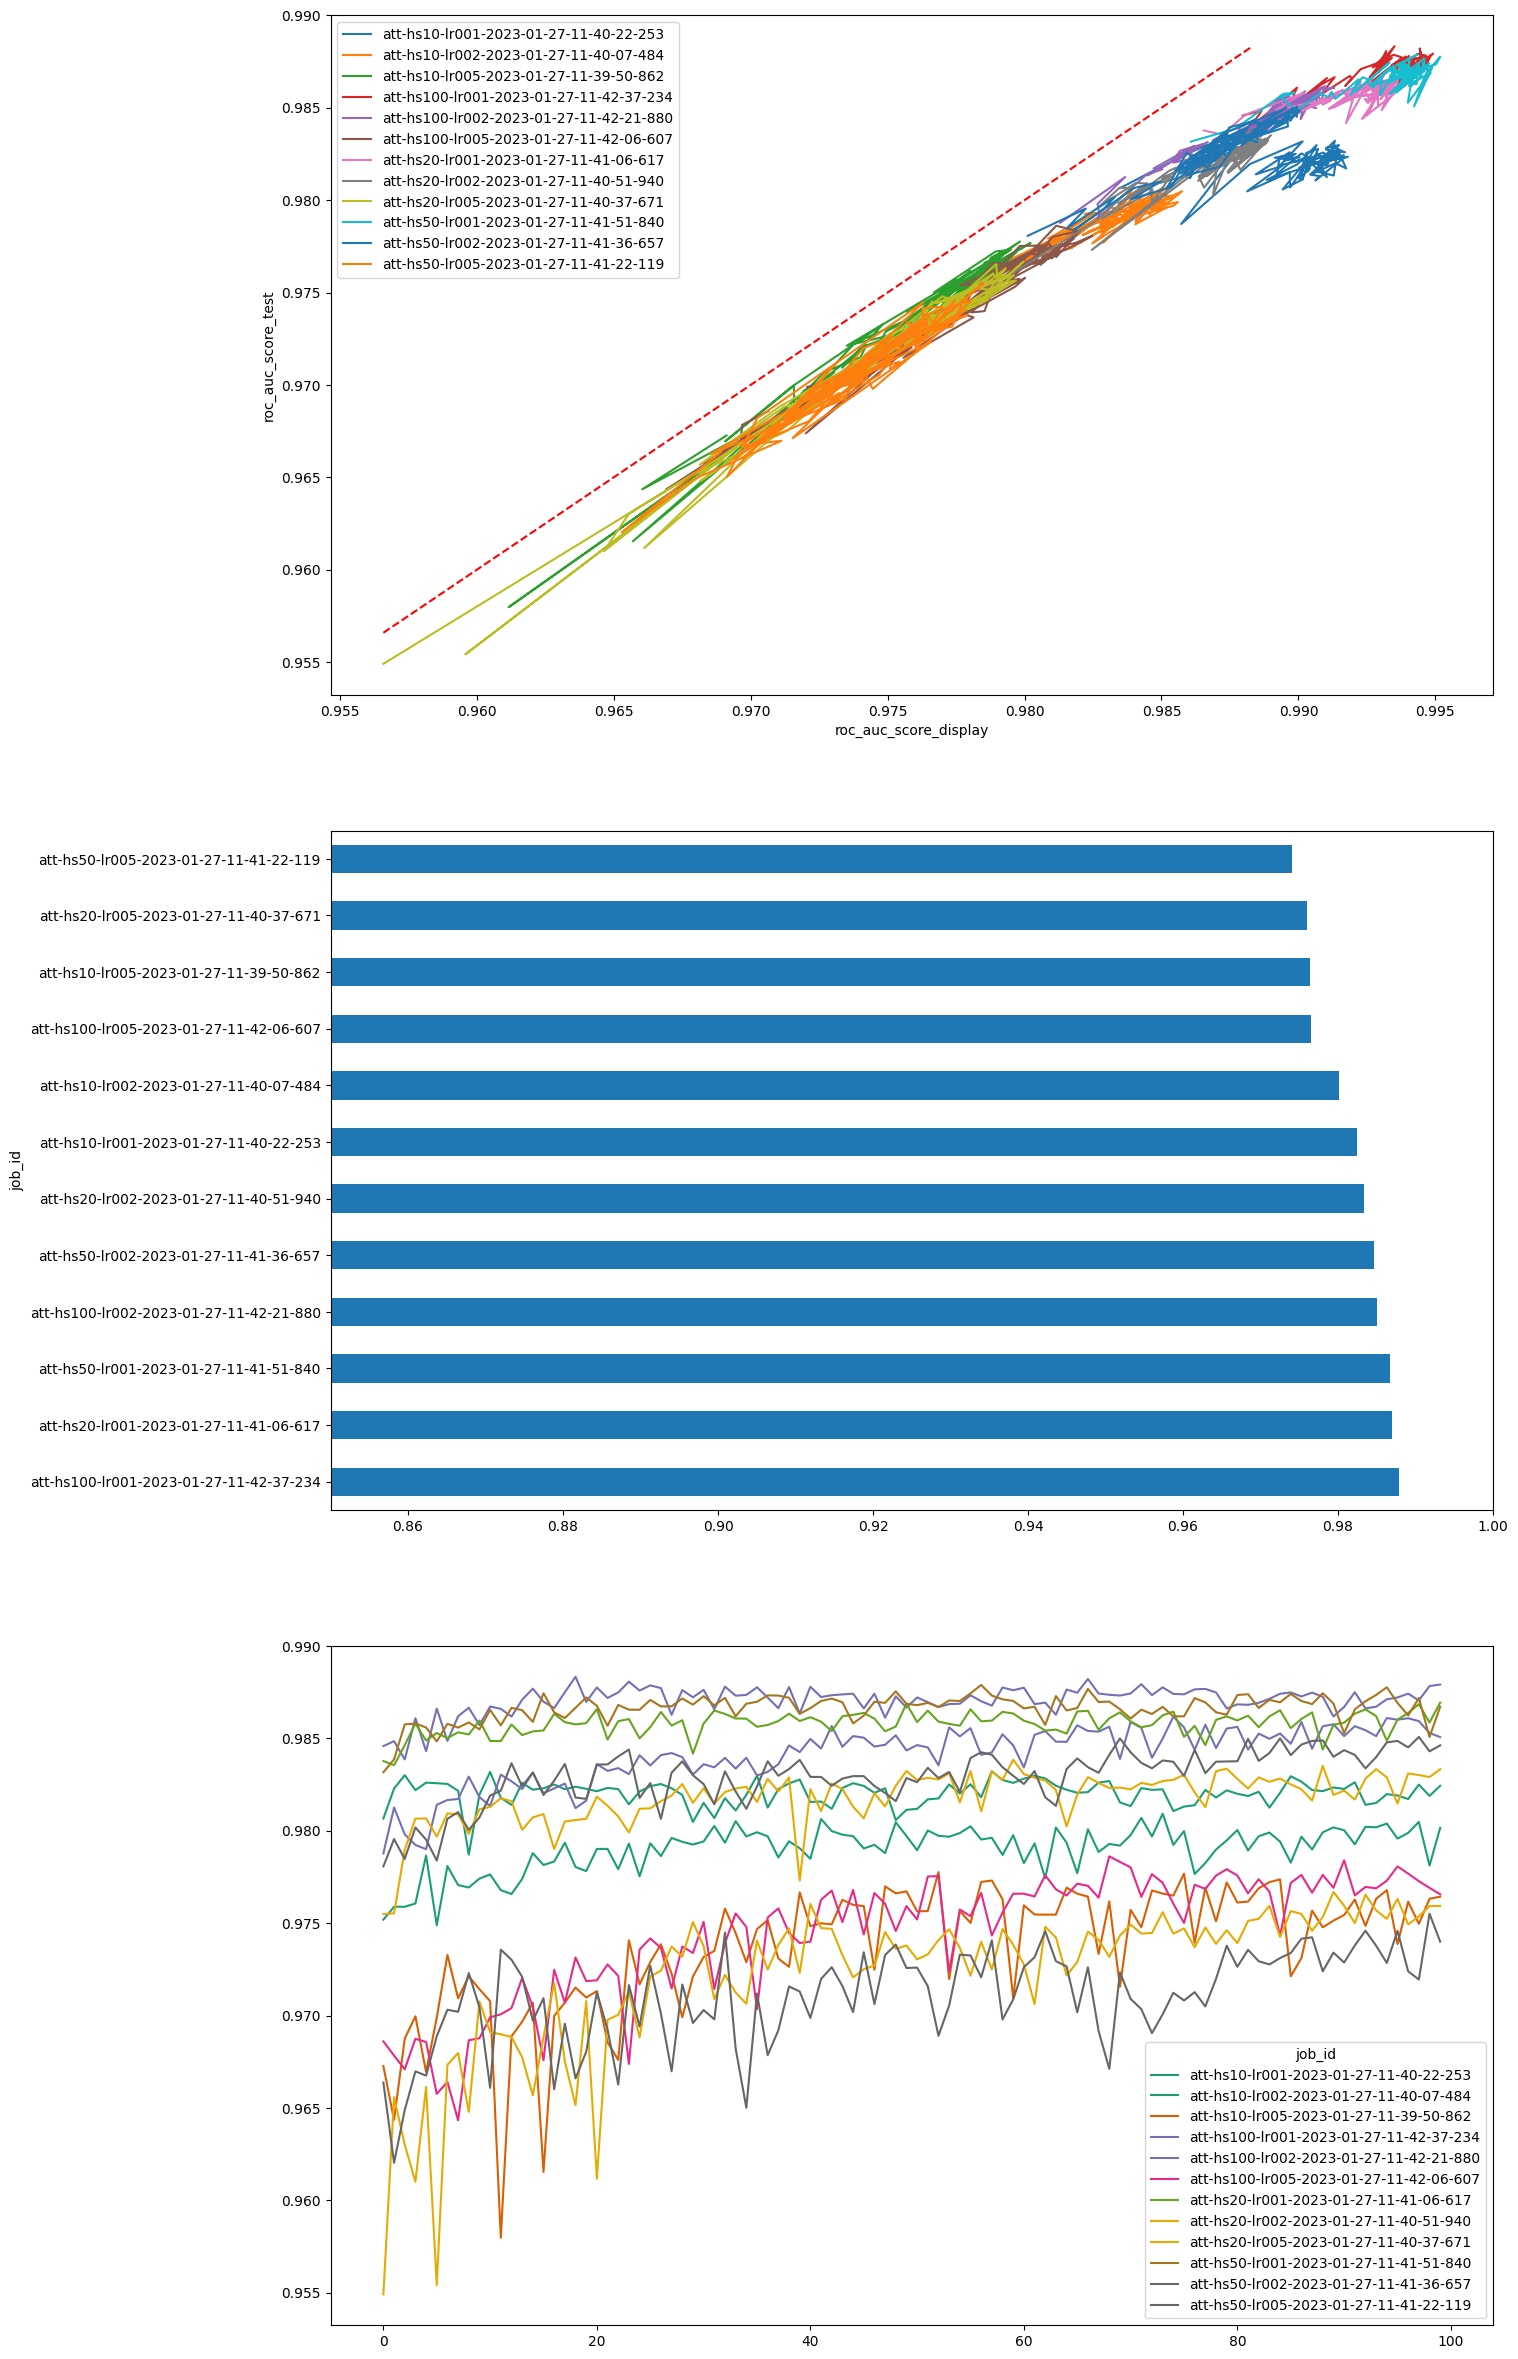

In [3]:
def plots_3(df):
    _, ax = plt.subplots(3,1,figsize=(15,30))
    tlw.draw_overfit(df, 'roc_auc_score_display', 'roc_auc_score_test', ax=ax[0])
    tlw.get_last_values(df).roc_auc_score_test.sort_values(ascending=False).plot(kind='barh', ax=ax[1])
    ax[1].set_xlim(0.85,1)
    tlw.get_metric_by_job(df, 'roc_auc_score_test').plot(ax=ax[2], cmap='Dark2')
    
plots_3(df)

## Context size and features

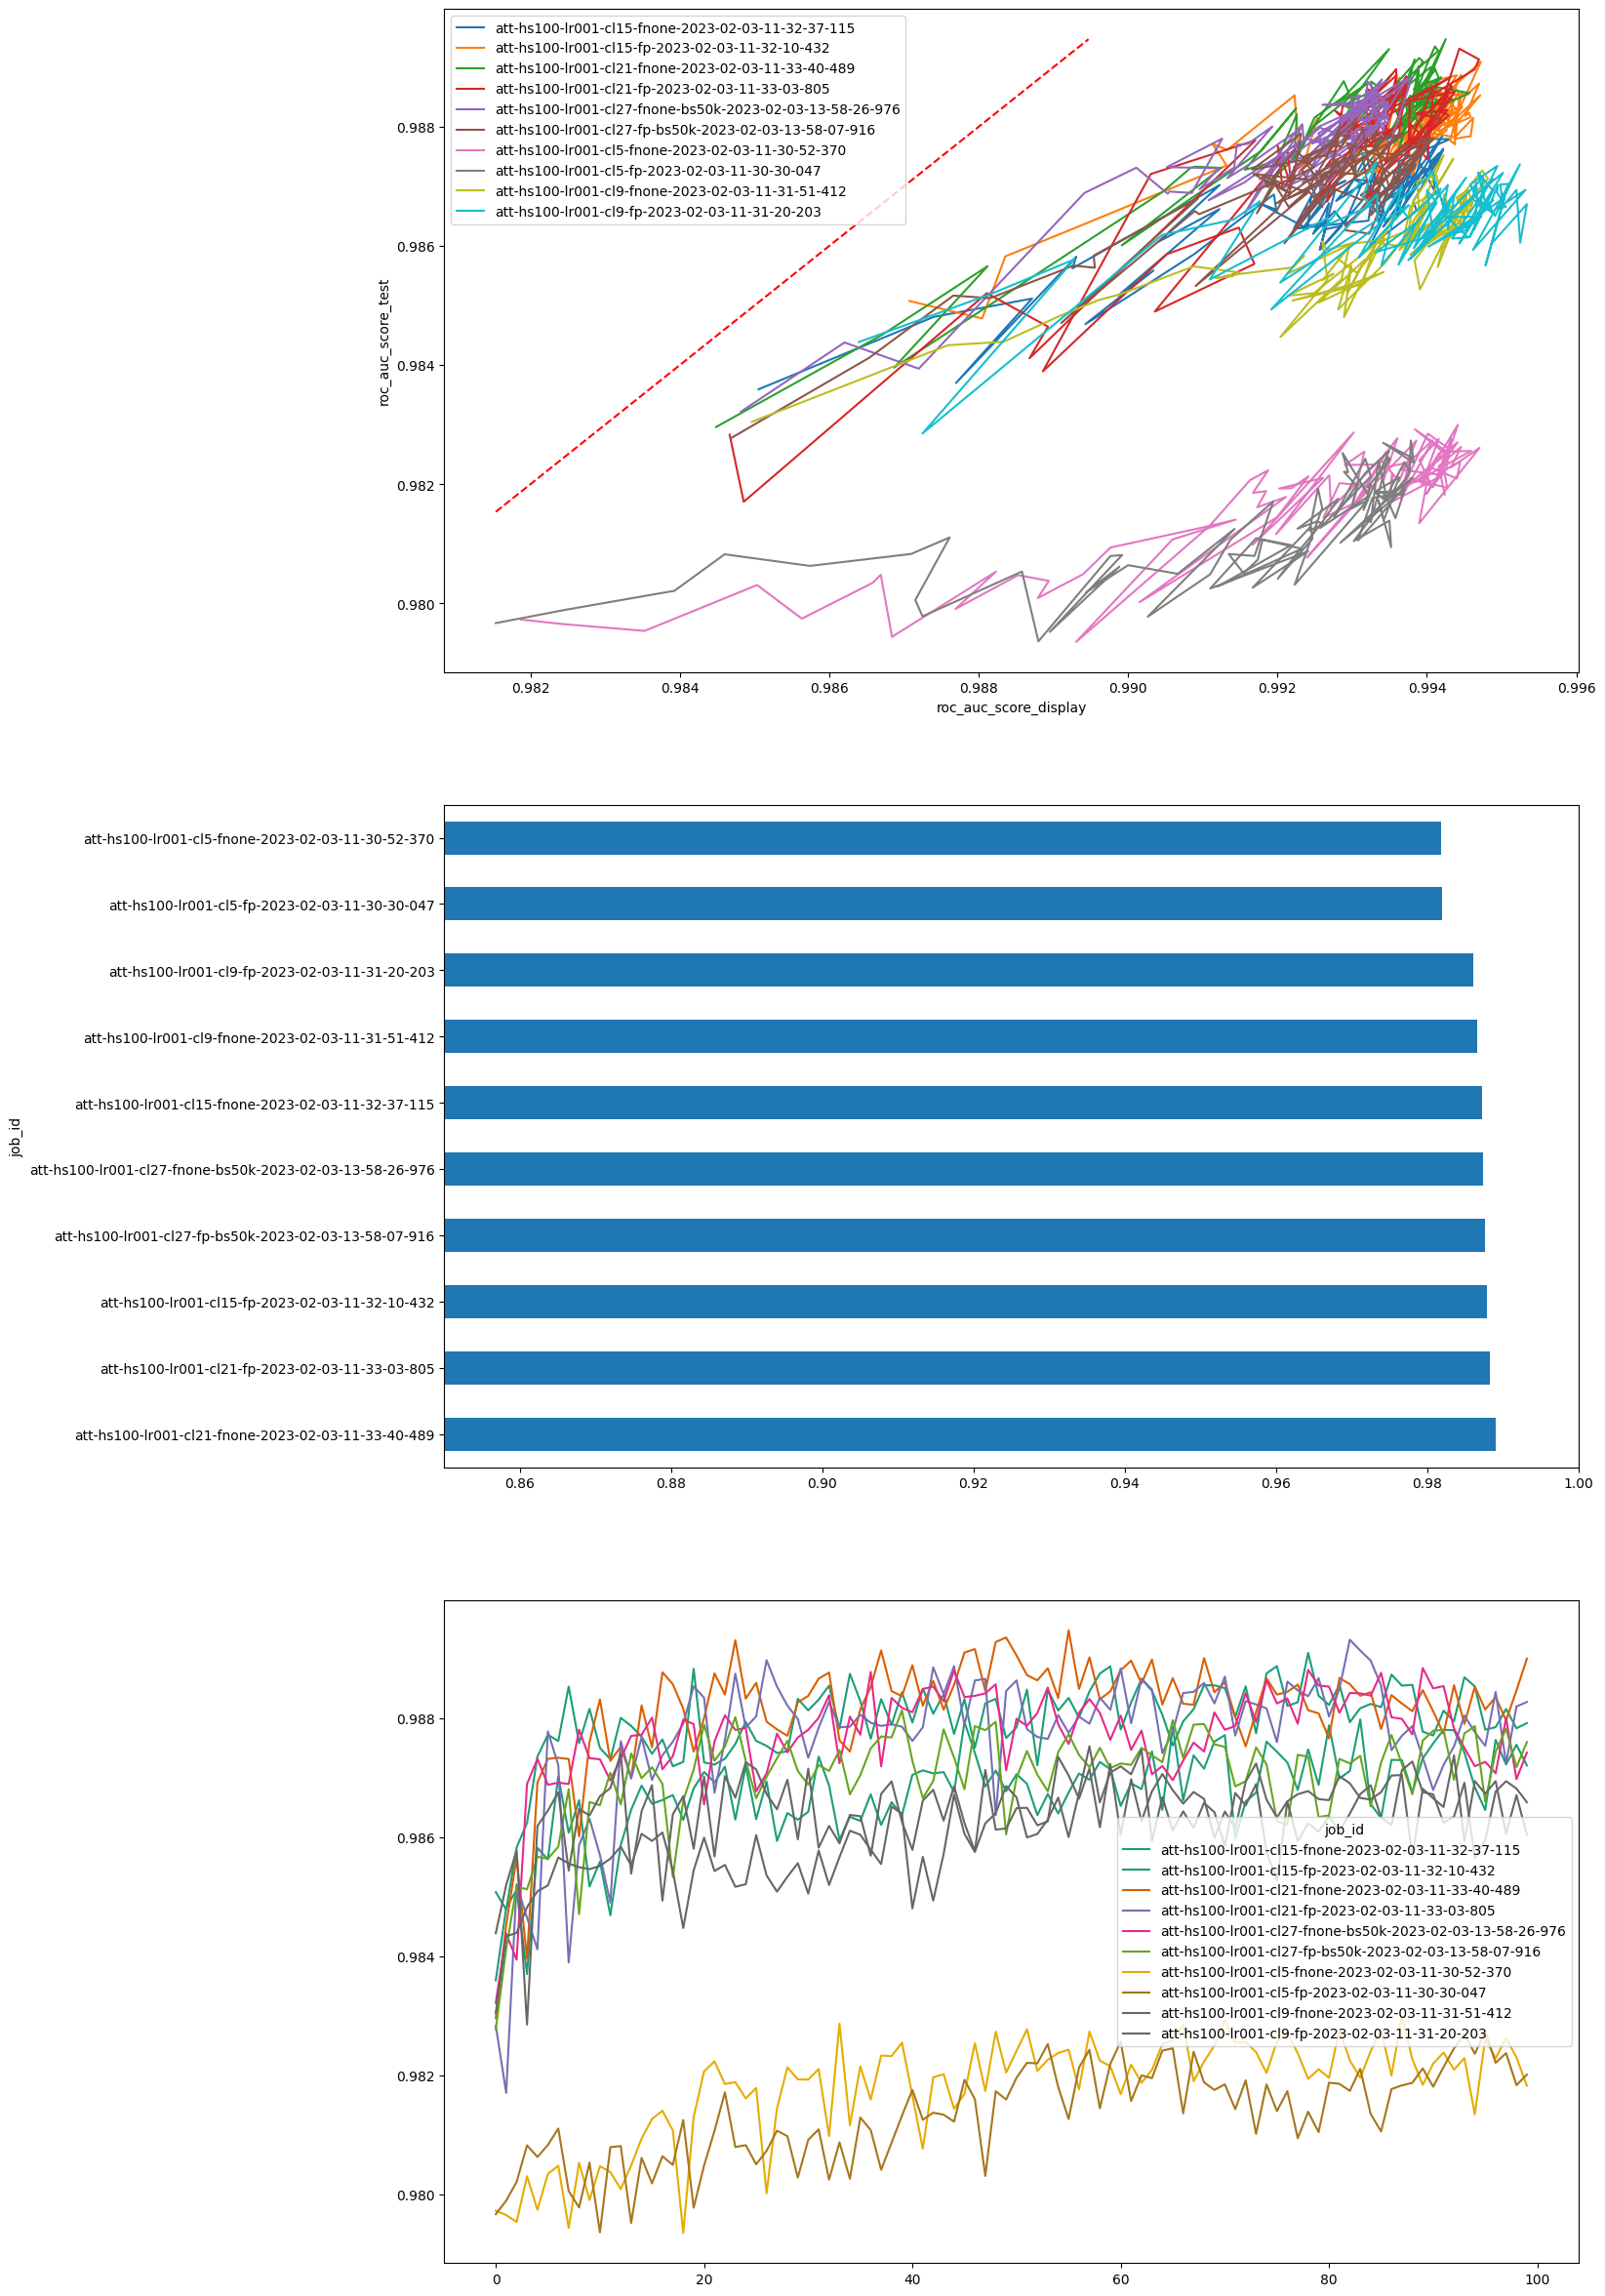

In [4]:
df = pd.read_parquet('files/params_1.parquet')
plots_3(df)

## Network type 

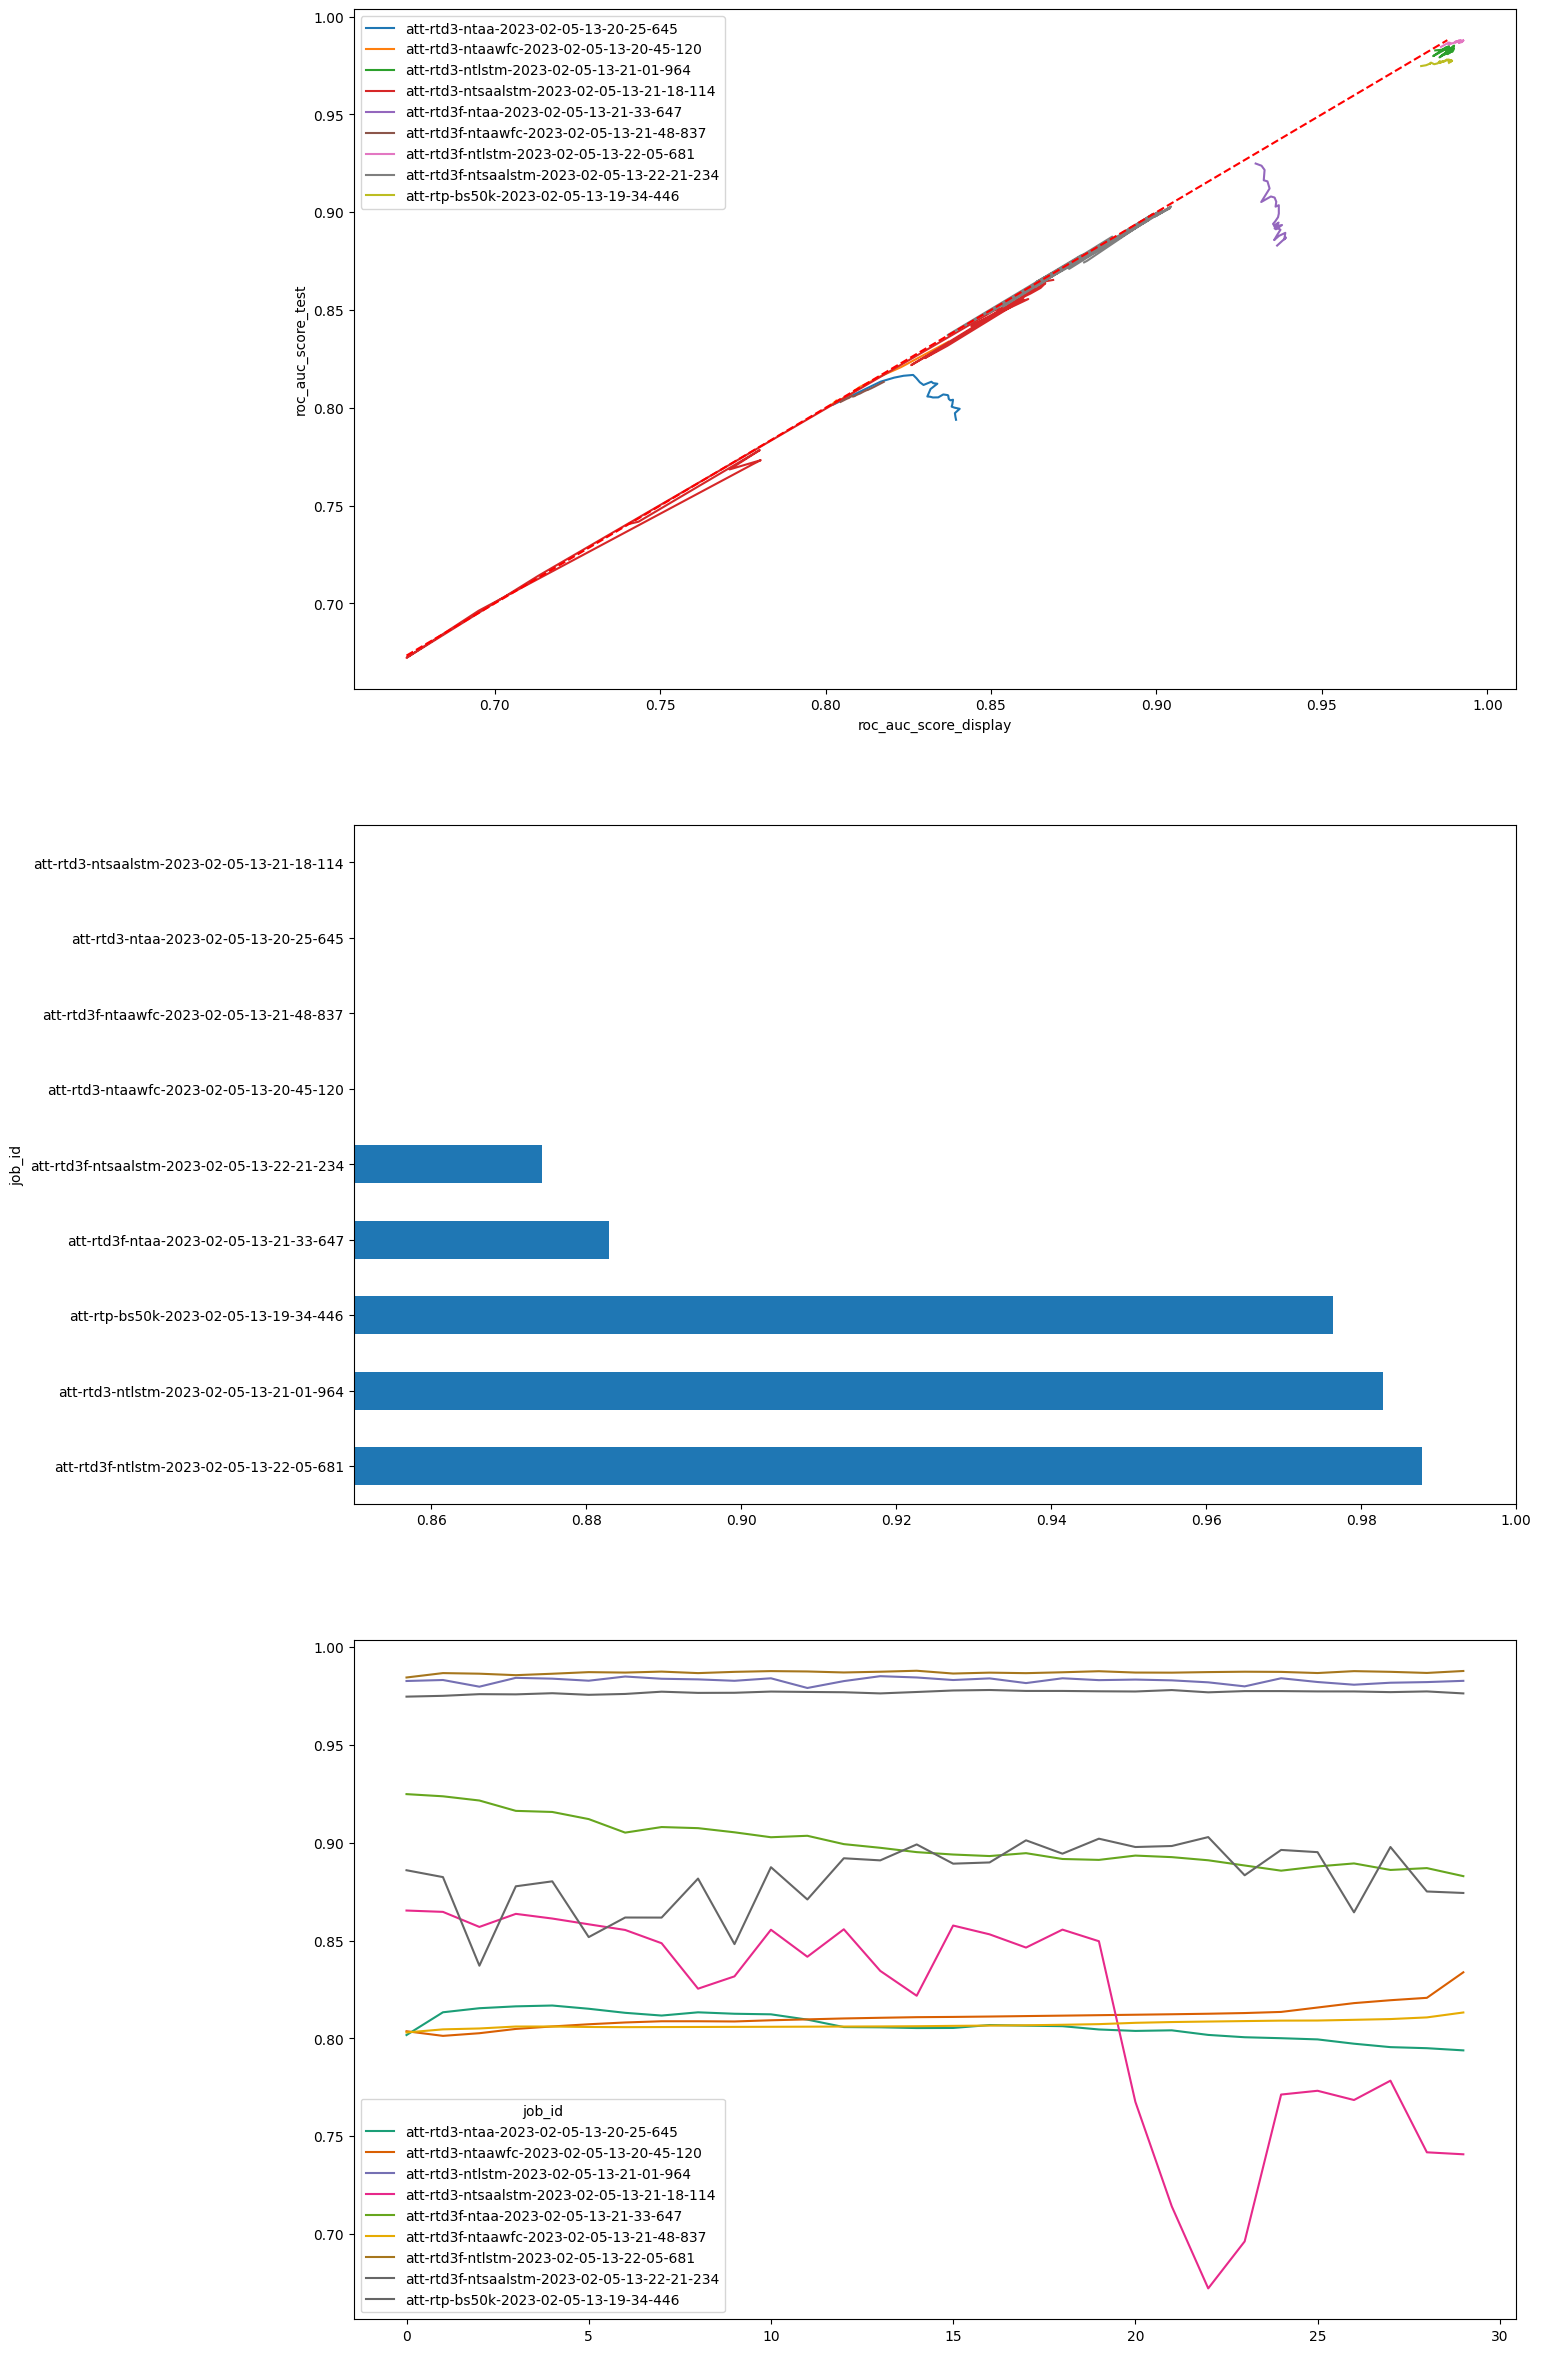

In [5]:
df = pd.read_parquet('files/params_2.parquet')
plots_3(df)

<AxesSubplot: >

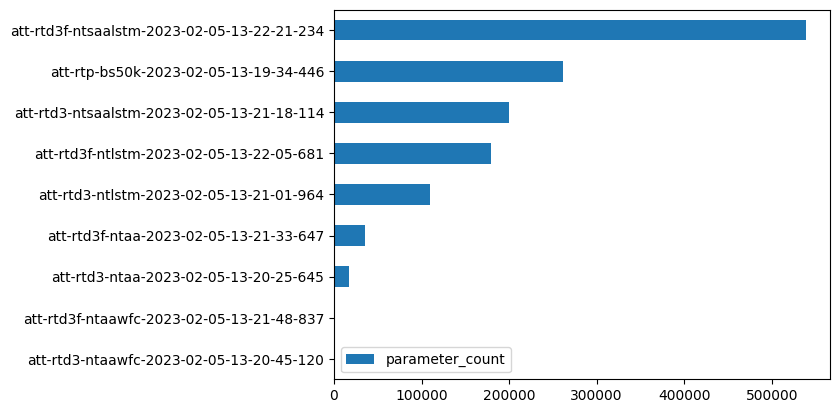

In [6]:
from tg.common.datasets.access import CacheMode
import torch
def get_parameters_count():
    rs = {}
    for job in job_ids:
        result = download_and_open_sagemaker_result(BUCKET,'alt',job,True)
        model = result.unpickle('output/model.pkl')
        rs[job] = sum([torch.numel(s) for s in model.network.parameters()])
    return pd.Series(rs).to_frame('parameter_count')

par_df = pd.read_parquet('files/parameters_count.parquet')
par_df.sort_values('parameter_count').plot(kind='barh')

# Deep Dive

To reproduce the following section, you would need a bundle that was used to train exactly this network!

In [7]:
from tg.grammar_ru import Loc

src = pd.read_parquet(Loc.data_cache_path/'bundles/alt/tsa-full/src.parquet')
src.head()

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,file_id,corpus_id,is_target,label,original_corpus,original_word_id,original_sentence_id,original_paragraph_id,updated
0,0,0,0,0,1,—,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,68,4,2,False
1,1,0,1,0,1,Фильм,ru,5,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,69,4,2,False
2,2,0,2,0,0,«,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,70,4,2,False
3,3,0,3,0,0,Растворяться,ru,12,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,True,0,pub.base.zip,71,4,2,False
4,4,0,4,0,1,»,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,72,4,2,False


In [8]:
{
    'sentences': src.drop_duplicates('sentence_id').shape[0]//1000,
    'words': src.shape[0] // 1000,
    'letters': src.word_length.sum()//1000000
}

{'sentences': 2, 'words': 49, 'letters': 0}

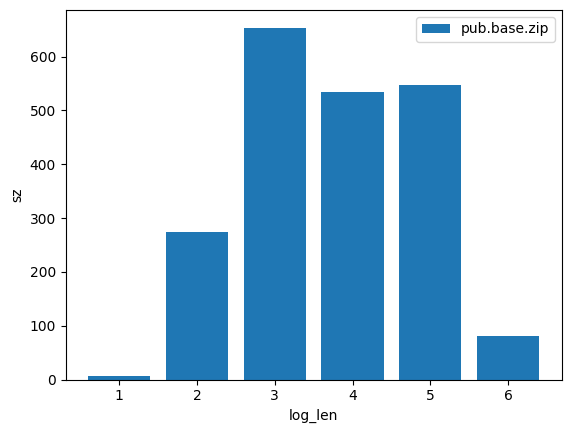

In [9]:
from tg.common.analysis import grbar_plot
import numpy as np

sdf = src.groupby(['original_corpus','sentence_id']).size().to_frame('len').reset_index()
sdf['log_len'] = np.log2(sdf.len)
sdf.log_len = sdf.log_len.astype(int)

grbar_plot(
    sdf.groupby(['original_corpus','log_len']).size().to_frame('sz').reset_index(),
    value_column='sz',
    group_column='log_len',
    color_column='original_corpus'
).legend()

In [10]:
job_id = 'att-rtd3-ntlstm-2023-02-05-13-21-01-964'
rdf = pd.read_parquet('files/result_df.parquet')
rdf.head()

,word_id,sentence_id,label,reference,split,true,predicted,stage
sample_id,,,,,,,,
3,3,0,0,pub.base.zip/0,test,0,0.924856,test
45,45,3,0,pub.base.zip/3,test,0,0.998233,test
118,118,76,1,pub.base.zip/76,test,1,0.991951,test
313,313,149,0,pub.base.zip/149,test,0,0.009378,test
382,382,331,1,pub.base.zip/331,test,1,0.979264,test


In [11]:
import numpy as np
from tg.common.ml.miscellaneous import roc_optimal_threshold

rdf = rdf.merge(sdf.set_index('sentence_id'),left_on='sentence_id',right_index=True)
borderline = roc_optimal_threshold(rdf.loc[rdf.split=='display'].true, rdf.loc[rdf.split=='display'].predicted)
rdf['predicted_label'] = np.where(rdf.predicted>borderline,1,0)
rdf['fail'] = rdf.predicted_label!=rdf.true
rdf.fail.mean()

0.03650190114068441

In [12]:
rows = []
for split in ['test','display']:
    for corp in rdf.original_corpus.unique():
        for log_len in rdf.log_len.unique():
            kdf = rdf.loc[(rdf.split==split) & (rdf.original_corpus==corp) & (rdf.log_len==log_len)]
            if kdf.shape[0]!=0 and len(kdf.true.unique())>1:
                rows.append(dict(
                    split=split, 
                    corp = corp, 
                    log_len = log_len,
                    scores = roc_auc_score(kdf.true, kdf.predicted),
                ))
xdf = pd.DataFrame(rows)

<AxesSubplot: xlabel='corp', ylabel='log_len'>

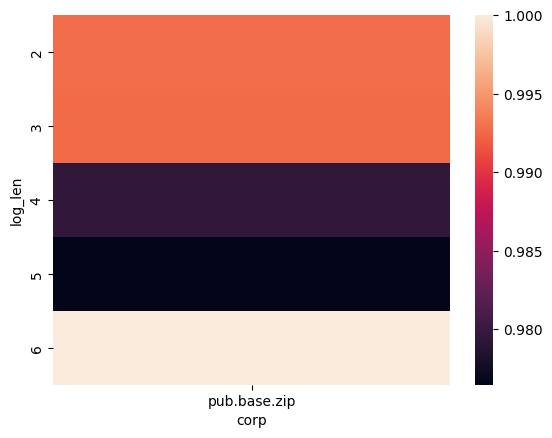

In [13]:
from seaborn import heatmap

heatmap(xdf.loc[xdf.split=='test'].pivot_table(columns='corp',index='log_len',values='scores'))

In [14]:
from tg.grammar_ru import Separator 

def represent(index, src, sample=None):
    index = index.loc[index.fail]
    if sample is not None:
        index = index.sample(sample)
    df = src
    df = df.merge(
        index.reset_index().set_index('sentence_id')[['sample_id']], 
        left_on='sentence_id', 
        right_index=True
    )
    df['mark'] = np.where(df.is_target, df.label.astype(str), 'no')
    return Separator.Viewer().tooltip('sample_id').highlight('mark', {'1':'#ffaaaa', '0':'#aaffaa'}).to_html_display(df)

represent(rdf.loc[(rdf.original_corpus=='books.base.zip') & (rdf.log_len==1)], src)

In [15]:
represent(rdf.loc[rdf.log_len>1], src, 10)